# 0.0 Imports

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error

import pickle

import warnings
warnings.filterwarnings("ignore")

# 0.1 Funções

In [94]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [95]:
def metricas_cv(X_train, y_train, nome_modelo, modelo):
    rmse_ = cross_val_score(modelo, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error")
    r2 = cross_val_score(modelo, X_train, y_train, cv=5, scoring="r2")
    mape = cross_val_score(modelo, X_train, y_train, cv=5, scoring="neg_mean_absolute_percentage_error")
    
    resultados = {"Modelo": nome_modelo, "r2_score": (np.mean(r2), np.std(r2)), "Mape": (np.mean(mape), np.std(mape)), "Rmse": (np.mean(rmse_), np.std(rmse_))}
    
    return resultados

In [96]:
def metricas(y_true, y_pred, nome_modelo):
    rmse_ = rmse(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    resultados = {"Modelo": nome_modelo, "r2_score": r2, "Mape": mape, "Rmse": rmse_}
    
    return resultados

# 1. Conhecendo os Dados

## 1.1 Primeiras Linhas

In [97]:
df_raw = pd.read_csv("kc_house_data.csv")
df_raw.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


## 1.2 Dimensões

In [98]:
print("Numero de linhas:",df_raw.shape[0])
print("Numero de colunas:",df_raw.shape[1])

Numero de linhas: 21613
Numero de colunas: 21


## 1.3 Integridade dos Dados

In [99]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

## 1.5 Estatísticas Descritivas

In [100]:
df_raw.describe().round(1)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0,21613.0
mean,4.580302e+09,540088.1,3.4,2.1,2079.9,15107.0,1.5,0.0,0.2,3.4,7.7,1788.4,291.5,1971.0,84.4,98077.9,47.6,-122.2,1986.6,12768.5
std,2.876566e+09,367127.2,0.9,0.8,918.4,41420.5,0.5,0.1,0.8,0.7,1.2,828.1,442.6,29.4,401.7,53.5,0.1,0.1,685.4,27304.2
min,1.000102e+06,75000.0,0.0,0.0,290.0,520.0,1.0,0.0,0.0,1.0,1.0,290.0,0.0,1900.0,0.0,98001.0,47.2,-122.5,399.0,651.0
25%,2.123049e+09,321950.0,3.0,1.8,1427.0,5040.0,1.0,0.0,0.0,3.0,7.0,1190.0,0.0,1951.0,0.0,98033.0,47.5,-122.3,1490.0,5100.0
50%,3.904930e+09,450000.0,3.0,2.2,1910.0,7618.0,1.5,0.0,0.0,3.0,7.0,1560.0,0.0,1975.0,0.0,98065.0,47.6,-122.2,1840.0,7620.0
75%,7.308900e+09,645000.0,4.0,2.5,2550.0,10688.0,2.0,0.0,0.0,4.0,8.0,2210.0,560.0,1997.0,0.0,98118.0,47.7,-122.1,2360.0,10083.0
max,9.900000e+09,7700000.0,33.0,8.0,13540.0,1651359.0,3.5,1.0,4.0,5.0,13.0,9410.0,4820.0,2015.0,2015.0,98199.0,47.8,-121.3,6210.0,871200.0


## 1.6 Engenharia de Variáveis

In [101]:
# Criando uma copia para trabalharmos em cima

df = df_raw.copy()

In [102]:
df["nivel_bairro"] = pd.qcut(df["sqft_living15"].values, q = 4, labels=[1, 2, 3, 4])
df.nivel_bairro = df.nivel_bairro.astype(int)

In [103]:
df["idade_casa"] = 2014 - df.yr_built

In [104]:
df["ja_reformado"] = [0 if i == 0 else 1 for i in df.yr_renovated.values.tolist()]

## 1.7 Limpeza

In [105]:
# Removendo as colunas que não irei usar

df.drop(["sqft_above", "sqft_basement", "zipcode", "sqft_lot15", "date", "yr_built", "yr_renovated", "sqft_living15"], axis=1, inplace=True)

### Análise e Remoção de Outliers

Nós já haviamos identificado os outliers no primeiro ciclo do projeto, vamos então utilizar as mesmas técnicas.

In [106]:
# Criando copia de segurança

dff = df.copy()

In [107]:
# Removendo outliers

df.drop(df[df.price > 1000000].index, axis=0, inplace=True)
df.drop(df[(df.bedrooms > 5)].index, axis=0, inplace=True)
df.drop(df[df.bathrooms > 4].index, axis=0, inplace=True)
df.drop(df[df.sqft_living > 4500].index, axis=0, inplace=True)
df.drop(df[df.sqft_lot > 20000].index, axis=0, inplace=True)
df.drop(df[df.condition == 1].index, axis=0, inplace=True)
df.drop(df[(df.grade > 10) | (df.grade < 6)].index, axis=0, inplace=True)

### Variável Alvo

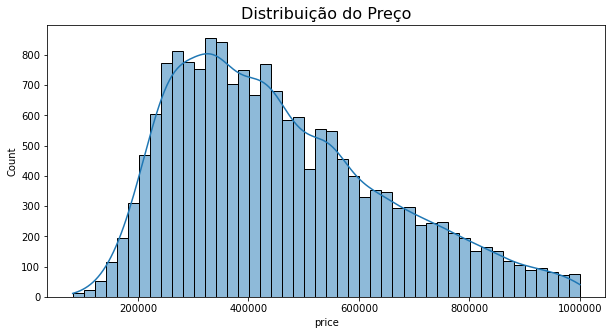

In [108]:
plt.figure(figsize=[10, 5])
sns.histplot(df.price, kde=True)
plt.ticklabel_format(style='plain', axis='x')
plt.title("Distribuição do Preço", fontsize=16);

In [53]:
print("Skew:", stats.skew(df.price.values))

Skew: 0.683136087493346


# 3. Modelagem

## 3.1 Pré-Processamento

### Seleção de Váriáveis

Para confirmar e quantificar a força da relação entre as variáveis, vamos plotar o gráfico de correlação:

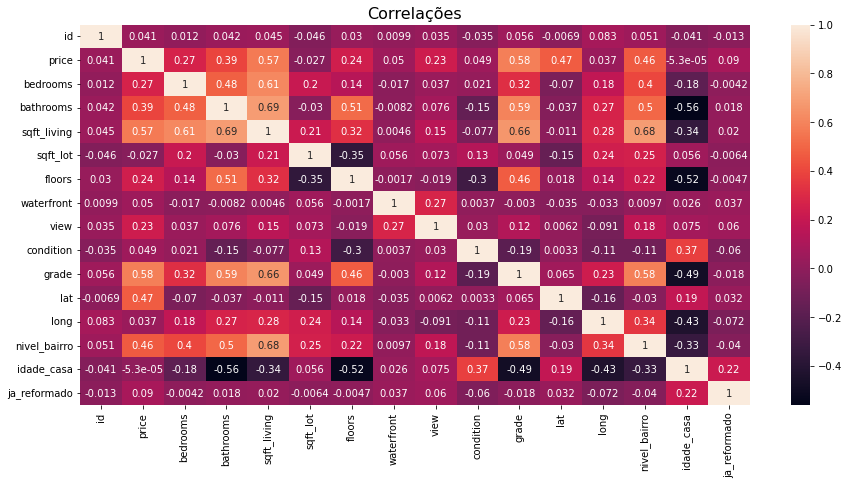

In [54]:
plt.figure(figsize=[15, 7])
sns.heatmap(df.corr(), annot=True)
plt.title("Correlações", fontsize=16)
plt.show()

In [109]:
df1 = df.copy()

In [110]:
df1.drop(["sqft_lot", "waterfront", "condition", "long", "idade_casa", "ja_reformado"], axis=1, inplace=True)

In [111]:
X = df1.drop(["price", "id"], axis=1).values
y = df1.price.values.reshape(-1, 1)

### Transformando as distribuições

In [58]:
#df1["sqft_living"] = np.log(df1["sqft_living"].values)
#df1["price"] = np.log(df1["price"].values)

### Colocando as variáveis em uma mesma escala

In [112]:
mm_scaler = MinMaxScaler()

X = mm_scaler.fit_transform(X)

### Separando treino e teste

In [113]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, random_state=42)

## 3.2 Treinamento

### Regressão linear

In [61]:
lm = LinearRegression()

In [62]:
lm.fit(Xtrain, ytrain)

LinearRegression()

In [63]:
metricas(y_true=ytrain, y_pred=lm.predict(Xtrain), nome_modelo="Reg.Linear Treino")

{'Modelo': 'Reg.Linear Treino',
 'r2_score': 0.6133861487845919,
 'Mape': 0.21027602503517653,
 'Rmse': 118076.85538038833}

In [64]:
metricas_cv(Xtrain, ytrain, "Reg.Linear Cross.Val", lm)

{'Modelo': 'Reg.Linear Cross.Val',
 'r2_score': (0.6121897495631295, 0.011937577160515817),
 'Mape': (-0.21044366435478795, 0.0053295994189676765),
 'Rmse': (-118171.96584772071, 2179.9284755915082)}

### Regressão Polinomial

In [65]:
poly = PolynomialFeatures(3)

In [66]:
Xtrain_poly = poly.fit_transform(Xtrain)
Xtest_poly = poly.fit_transform(Xtest)

In [67]:
lm.fit(Xtrain_poly, ytrain)

LinearRegression()

In [68]:
metricas(y_true=ytrain, y_pred=lm.predict(Xtrain_poly), nome_modelo="Reg.Polinomial Treino")

{'Modelo': 'Reg.Polinomial Treino',
 'r2_score': 0.7684996996046636,
 'Mape': 0.1657777753408488,
 'Rmse': 91369.62726405005}

In [ ]:
metricas_cv(Xtrain_poly, ytrain, "Reg.Polinomial Cross.Val", lm)

{'Modelo': 'Reg.Polinomial Cross.Val',
 'r2_score': (0.759731395828518, 0.005858283560223898),
 'Mape': (-0.16812421872935895, 0.004008244189134865),
 'Rmse': (-93029.00877516613, 1988.0937852287018)}

### Random Forest

In [69]:
forest = RandomForestRegressor(min_samples_leaf = 8, random_state = 42)

In [70]:
forest.fit(Xtrain, ytrain)

RandomForestRegressor(min_samples_leaf=8, random_state=42)

In [71]:
metricas(y_true=ytrain, y_pred=forest.predict(Xtrain), nome_modelo="Random Forest Treino")

{'Modelo': 'Random Forest Treino',
 'r2_score': 0.8674073629080944,
 'Mape': 0.11480175676507745,
 'Rmse': 69148.97993533262}

In [72]:
metricas_cv(Xtrain, ytrain, "Random Forest Cross.Val", forest)

{'Modelo': 'Random Forest Cross.Val',
 'r2_score': (0.8004802761156717, 0.003496602204491986),
 'Mape': (-0.1406975742523134, 0.0018494606943251879),
 'Rmse': (-84767.9132810024, 1111.7432765414449)}

### Gradient Boosting

In [73]:
boost = GradientBoostingRegressor(min_samples_leaf = 8, subsample = 0.8)

In [74]:
boost.fit(Xtrain, ytrain)

GradientBoostingRegressor(min_samples_leaf=8, subsample=0.8)

In [75]:
metricas(y_true=ytrain, y_pred=boost.predict(Xtrain), nome_modelo="G.Boost Treino")

{'Modelo': 'G.Boost Treino',
 'r2_score': 0.8114413998518506,
 'Mape': 0.13985496135417746,
 'Rmse': 82461.12328541333}

In [76]:
metricas_cv(Xtrain, ytrain, "G.boost Cross.Val", boost)

{'Modelo': 'G.boost Cross.Val',
 'r2_score': (0.7982926098631775, 0.002634484069196448),
 'Mape': (-0.14362774631083897, 0.0030304858562212405),
 'Rmse': (-85252.14050336152, 1722.8990452358985)}

Dos modelos testados, o que aprendeu a generalizar melhor foi o modelo de Gradient Boosting, iremos usá-lo para realizar as predições.

## 3.3 Otimização de Hiperparâmetros

In [ ]:
params = {"min_samples_split":[5, 8, 13],
          "max_depth":[3, 5, 8, 13, 21, 34],
          "max_features":["auto", "sqrt", "log2"],
          "learning_rate":[0.1, 0.15, 0.2]}

reg = RandomizedSearchCV(GradientBoostingRegressor(subsample=0.8), param_distributions=params, n_iter=50, cv=5, scoring="neg_root_mean_squared_error")
reg.fit(Xtrain, ytrain)
print(reg.best_params_)
print()
print(reg.best_score_)

{'min_samples_split': 5, 'max_features': 'log2', 'max_depth': 8, 'learning_rate': 0.1}

-81768.6058905597


In [77]:
final_model = GradientBoostingRegressor(min_samples_split=5, max_features="log2", max_depth=8)
final_model.fit(Xtrain, ytrain)

GradientBoostingRegressor(max_depth=8, max_features='log2', min_samples_split=5)

In [26]:
metricas_cv(Xtrain, ytrain, "Modelo Final", final_model)

{'Modelo': 'Modelo Final',
 'r2_score': (0.8111761601313641, 0.0050687841638260775),
 'Mape': (-0.1379665280537159, 0.0024297329106308303),
 'Rmse': (-82299.55818311879, 1457.5882718421042)}

## 3.4 Avaliação Final

Agora vamos avaliar o modelo final nos dados de teste, para ver se está generalizando para dados não vistos.

In [27]:
metricas(y_true=ytest, y_pred=final_model.predict(Xtest), nome_modelo="Modelo Final - Dados Teste")

{'Modelo': 'Modelo Final - Dados Teste',
 'r2_score': 0.8261888867873443,
 'Mape': 0.13273004881945516,
 'Rmse': 79921.58686258024}

Nosso modelo consegue "explicar" 82% da variabilidade do fenômeno avaliado - preço das casas. 

O erro médio é aproximadamente 13% do valor real. 

O RMSE pode parecer alto, mas vale ressaltar que possuímos imóveis de até 1 milhão de dólares, o erro relativo a casas muito caras pesa no cálculo do RMSE que da pesos maiores a erros maiores. Então se pensar por esta maneira verá o modelo performa na realidade, bem.

## 3.5 Exportando Modelo e Pipeline

Exportando o modelo em .pkl para colocá-lo em produção posteriormente.

In [ ]:
# Tranformadores

pickle.dump(mm_scaler, open("mm_scaler.pkl", "wb"))

In [ ]:
pickle.dump(final_model, open("house_sales_model.pkl", "wb"))

## 3.6 Performance de Negócio

In [114]:
dff.drop(["sqft_lot", "waterfront", "condition", "long", "idade_casa", "ja_reformado"], axis=1, inplace=True)
X = dff.drop(["price", "id"], axis=1).values
y = dff.price.values.reshape(-1, 1)

X = mm_scaler.transform(X)

In [115]:
valores_estimados = np.round(final_model.predict(X), 2)

In [117]:
df_temp = dff[["id", "price"]]

In [118]:
df_temp["valor_estimado"] = valores_estimados

In [119]:
valor_venda=[]

for _, row in df_temp.iterrows():
    if row["price"] >= row["valor_estimado"]:
        valor = row["price"] + (0.1 * row["price"])
        valor_venda.append(valor)
    elif row["price"] < row["valor_estimado"]:
        valor = row["price"] + (row["valor_estimado"] - row["price"]) + (0.1 * row["price"])
        valor_venda.append(valor)
    else:
        print("Algo deu errado!")
        
df_temp["valor_venda"] = valor_venda
df_temp["lucro"] = df_temp.valor_venda - df_temp.price

In [120]:
df_temp

,id,price,valor_estimado,valor_venda,lucro
0,7129300520,221900.0,274055.79,296245.79,74345.79
1,6414100192,538000.0,537494.03,591800.00,53800.00
2,5631500400,180000.0,179424.22,198000.00,18000.00
3,2487200875,604000.0,380962.54,664400.00,60400.00
4,1954400510,510000.0,577803.24,628803.24,118803.24
...,...,...,...,...,...
21608,263000018,360000.0,425904.00,461904.00,101904.00
21609,6600060120,400000.0,418324.62,458324.62,58324.62
21610,1523300141,402101.0,355283.81,442311.10,40210.10
21611,291310100,400000.0,383593.41,440000.00,40000.00


In [121]:
print(f"O lucro total com esta estratégia é de: R$ {df_temp.lucro.sum():,.2f}")

O lucro total com esta estratégia é de: R$ 1,654,681,700.24


Utilizando o modelo de precificação desenvolvido conseguimos elevar o lucro da empresa em 505,444 milhões (cerca de 43%) comparado com a estratégia anterior.